In [1]:
import sys
import os
project_path = '../../..'
sys.path.append(os.path.abspath(project_path))

In [2]:
from matplotlib import pyplot as plt
import numpy as np

# Load Synthetic Data

In [3]:
num_states = 3
D = 1
emission_dist = 't'
save_path = '2013-2018_3states'
folder_path = f"{project_path}/data/synthetic/{emission_dist}-hmm/{save_path}"
s_filename = f"{folder_path}/S_data.npy"
x_filename = f"{folder_path}/X_data.npy"
S = np.load(s_filename)
X = np.load(x_filename)

In [4]:
from data_code.dataloader import create_dataloaders, create_datasets

window_size = 390
batch_size = 32

train_loader, val_loader, test_loader = create_dataloaders(
    X, S, window_size=window_size, train_ratio=0.6, val_ratio=0.2, batch_size=batch_size, standardize=True, feature_engineer=True
)

# Search the Best Hyper-parameter for Mixture-VAE

In [5]:
class ModelParams:
    name = 'mixture_vae'
    
    # backbone parameters
    tau = 0.1
    hard = False
    transition = 'jump'
    lamda_m = 1.0
    lamda_i = 1.0
    lamda_t = 1.0
    seq_len = window_size
    feature = D * 15
    n_cluster = num_states
    hidden_dim = 16
    loss_clamp = batch_size * window_size * 10
    loss_mode = 'sum'
    
    # s_x
    s_x_type = 'lstm'
    s_clamp = 5
    s_x_dropout = 0.1
    s_x_lstm_hidden = 64
    s_x_lstm_layers = 1
    
    # z_s (p)
    
    # z_sx (q)
    z_sx_type = 'mlp'
    z_sx_dropout = 0.1
    z_sx_hiddens = [128, 128]
    
    ######################################
    reconstruction_on_s = True # if True use x_sz else x_z
    
    # x_sz
    x_sz_type = 'mlp'
    reconstruction_on_z = 'p'
    x_sz_dropout = 0.1
    x_sz_hiddens = [128, 128]
    
    # x_z
    x_z_type = 'mlp'
    reconstruction_on_z = 'p'
    x_z_dropout = 0.1
    x_z_hiddens = [128, 128]

model_params = ModelParams

In [6]:
import optuna
import numpy as np
import json
from model.vae_module import VAEModule
from utils.metrics import balanced_accuracy
import os

# Construct the grid for lamda
grid_values = [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 9.0, 12.0, 15.0, 20.0, 30.0, 40.0, 60.0, 80.0, 100.0]

def objective(trial):
    # Select a lamda value from the predefined grid
    lamda = trial.suggest_categorical("lamda", grid_values)
    
    # Assign the lamda value to the model parameters
    model_params.lamda_m = lamda
    model_params.lamda_i = lamda
    model_params.lamda_t = lamda
    
    vae_module = VAEModule(model_params)
    vae_module.fit(train_loader, lr=1e-3, epochs=300)
    
    # Evaluate model performance on the validation set
    true_s_val, pred_s_val = vae_module.inference(val_loader)
    val_bal_acc = balanced_accuracy(true_s_val.ravel(), pred_s_val.ravel(), n_classes=num_states)
    
    return val_bal_acc

# Define the search space
search_space = {"lamda": grid_values}
sampler = optuna.samplers.GridSampler(search_space)

# Create an Optuna Study with the objective of maximizing Balanced Accuracy
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective)

# Output the best hyperparameters
print("Best trial:")
best_trial = study.best_trial
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Save the best hyperparameters to a file
best_params = best_trial.params

os.makedirs(f"{project_path}/hyper_parameter/best_vae", exist_ok=True)
param_file_name = f"{project_path}/hyper_parameter/best_vae/{save_path}.json"
with open(param_file_name, "w") as f:
    json.dump(best_params, f, indent=4)

print("Best hyperparameters saved to 'best_hyperparameters.json'.")


[I 2025-03-24 13:59:09,026] A new study created in memory with name: no-name-b3b5f54c-1494-4c50-b96a-f363b82e2b47


Epoch [20/300], VAE Loss: 6156.6026
Epoch [40/300], VAE Loss: 6024.7173
Epoch [60/300], VAE Loss: 5995.6000
Epoch [80/300], VAE Loss: 5988.1071
Epoch [100/300], VAE Loss: 5973.9557
Epoch [120/300], VAE Loss: 5965.8791
Epoch [140/300], VAE Loss: 5963.8584
Epoch [160/300], VAE Loss: 5960.2063
Epoch [180/300], VAE Loss: 5953.0987
Epoch [200/300], VAE Loss: 5949.3937
Epoch [220/300], VAE Loss: 5952.8545
Epoch [240/300], VAE Loss: 5950.2450
Epoch [260/300], VAE Loss: 5943.4821
Epoch [280/300], VAE Loss: 5942.8557


[I 2025-03-24 13:59:46,793] Trial 0 finished with value: 0.5910944715795581 and parameters: {'lamda': 2.0}. Best is trial 0 with value: 0.5910944715795581.


Epoch [300/300], VAE Loss: 5940.5822
Epoch [20/300], VAE Loss: 13120.0298
Epoch [40/300], VAE Loss: 12650.0792
Epoch [60/300], VAE Loss: 12557.7292
Epoch [80/300], VAE Loss: 12511.5411
Epoch [100/300], VAE Loss: 12477.3807
Epoch [120/300], VAE Loss: 12434.2245
Epoch [140/300], VAE Loss: 12413.1373
Epoch [160/300], VAE Loss: 12415.5925
Epoch [180/300], VAE Loss: 12398.8268
Epoch [200/300], VAE Loss: 12377.1771
Epoch [220/300], VAE Loss: 12376.9338
Epoch [240/300], VAE Loss: 12366.3542
Epoch [260/300], VAE Loss: 12370.6166
Epoch [280/300], VAE Loss: 12368.9592


[I 2025-03-24 14:00:32,978] Trial 1 finished with value: 0.6215014640071507 and parameters: {'lamda': 9.0}. Best is trial 1 with value: 0.6215014640071507.


Epoch [300/300], VAE Loss: 12362.9238
Epoch [20/300], VAE Loss: 18730.9067
Epoch [40/300], VAE Loss: 17991.7392
Epoch [60/300], VAE Loss: 17815.8403
Epoch [80/300], VAE Loss: 17738.8047
Epoch [100/300], VAE Loss: 17694.0464
Epoch [120/300], VAE Loss: 17631.5404
Epoch [140/300], VAE Loss: 17572.7406
Epoch [160/300], VAE Loss: 17541.6485
Epoch [180/300], VAE Loss: 17535.1172
Epoch [200/300], VAE Loss: 17518.8997
Epoch [220/300], VAE Loss: 17521.5362
Epoch [240/300], VAE Loss: 17486.4620
Epoch [260/300], VAE Loss: 17481.5231
Epoch [280/300], VAE Loss: 17478.0690


[I 2025-03-24 14:01:19,242] Trial 2 finished with value: 0.6285486137127073 and parameters: {'lamda': 15.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 17455.7508
Epoch [20/300], VAE Loss: 22595.5315
Epoch [40/300], VAE Loss: 22102.9449
Epoch [60/300], VAE Loss: 21944.6646
Epoch [80/300], VAE Loss: 21839.4150
Epoch [100/300], VAE Loss: 21779.3243
Epoch [120/300], VAE Loss: 21735.2839
Epoch [140/300], VAE Loss: 21709.0221
Epoch [160/300], VAE Loss: 21680.1626
Epoch [180/300], VAE Loss: 21665.9326
Epoch [200/300], VAE Loss: 21647.1291
Epoch [220/300], VAE Loss: 21627.8570
Epoch [240/300], VAE Loss: 21624.2880
Epoch [260/300], VAE Loss: 21615.2802
Epoch [280/300], VAE Loss: 21610.9971


[I 2025-03-24 14:02:05,577] Trial 3 finished with value: 0.47180333582799827 and parameters: {'lamda': 20.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 21605.4726
Epoch [20/300], VAE Loss: 87597.7059
Epoch [40/300], VAE Loss: 86285.5931
Epoch [60/300], VAE Loss: 85838.3072
Epoch [80/300], VAE Loss: 85590.6585
Epoch [100/300], VAE Loss: 85427.8219
Epoch [120/300], VAE Loss: 85304.3415
Epoch [140/300], VAE Loss: 85217.1291
Epoch [160/300], VAE Loss: 85144.7337
Epoch [180/300], VAE Loss: 85095.1324
Epoch [200/300], VAE Loss: 85056.8562
Epoch [220/300], VAE Loss: 85024.4314
Epoch [240/300], VAE Loss: 84999.8448
Epoch [260/300], VAE Loss: 84972.2761
Epoch [280/300], VAE Loss: 84952.0964


[I 2025-03-24 14:02:51,925] Trial 4 finished with value: 0.3930872711899435 and parameters: {'lamda': 100.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 84932.7386
Epoch [20/300], VAE Loss: 9673.6070
Epoch [40/300], VAE Loss: 9093.9831
Epoch [60/300], VAE Loss: 8882.2797
Epoch [80/300], VAE Loss: 8850.1545
Epoch [100/300], VAE Loss: 8828.2890
Epoch [120/300], VAE Loss: 8812.9251
Epoch [140/300], VAE Loss: 8800.6013
Epoch [160/300], VAE Loss: 8785.1722
Epoch [180/300], VAE Loss: 8788.0449
Epoch [200/300], VAE Loss: 8774.4477
Epoch [220/300], VAE Loss: 8767.9699
Epoch [240/300], VAE Loss: 8757.3902
Epoch [260/300], VAE Loss: 8744.5870
Epoch [280/300], VAE Loss: 8750.4868


[I 2025-03-24 14:03:38,476] Trial 5 finished with value: 0.5938825539598506 and parameters: {'lamda': 5.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 8764.2509
Epoch [20/300], VAE Loss: 7606.6840
Epoch [40/300], VAE Loss: 7019.1292
Epoch [60/300], VAE Loss: 6973.7823
Epoch [80/300], VAE Loss: 6950.9154
Epoch [100/300], VAE Loss: 6937.5892
Epoch [120/300], VAE Loss: 6929.3752
Epoch [140/300], VAE Loss: 6920.1499
Epoch [160/300], VAE Loss: 6918.0494
Epoch [180/300], VAE Loss: 6906.1806
Epoch [200/300], VAE Loss: 6903.3102
Epoch [220/300], VAE Loss: 6903.5366
Epoch [240/300], VAE Loss: 6896.8204
Epoch [260/300], VAE Loss: 6893.7069
Epoch [280/300], VAE Loss: 6885.9459


[I 2025-03-24 14:04:24,903] Trial 6 finished with value: 0.5903502720678045 and parameters: {'lamda': 3.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 6889.4645
Epoch [20/300], VAE Loss: 73235.5515
Epoch [40/300], VAE Loss: 70852.4869
Epoch [60/300], VAE Loss: 70323.9853
Epoch [80/300], VAE Loss: 70037.2337
Epoch [100/300], VAE Loss: 69834.5882
Epoch [120/300], VAE Loss: 69691.5163
Epoch [140/300], VAE Loss: 69589.1928
Epoch [160/300], VAE Loss: 69495.7288
Epoch [180/300], VAE Loss: 69421.7770
Epoch [200/300], VAE Loss: 69363.2051
Epoch [220/300], VAE Loss: 69319.2810
Epoch [240/300], VAE Loss: 69283.4910
Epoch [260/300], VAE Loss: 69255.0498
Epoch [280/300], VAE Loss: 69227.6667


[I 2025-03-24 14:05:11,265] Trial 7 finished with value: 0.3625636645301438 and parameters: {'lamda': 80.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 69205.4077
Epoch [20/300], VAE Loss: 31669.2447
Epoch [40/300], VAE Loss: 30193.7815
Epoch [60/300], VAE Loss: 30003.9093
Epoch [80/300], VAE Loss: 29897.6769
Epoch [100/300], VAE Loss: 29829.4971
Epoch [120/300], VAE Loss: 29778.1458
Epoch [140/300], VAE Loss: 29733.4183
Epoch [160/300], VAE Loss: 29704.8583
Epoch [180/300], VAE Loss: 29686.4555
Epoch [200/300], VAE Loss: 29670.9980
Epoch [220/300], VAE Loss: 29658.1634
Epoch [240/300], VAE Loss: 29646.2757
Epoch [260/300], VAE Loss: 29638.0482
Epoch [280/300], VAE Loss: 29627.0445


[I 2025-03-24 14:05:57,415] Trial 8 finished with value: 0.4883525210269026 and parameters: {'lamda': 30.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 29619.6111
Epoch [20/300], VAE Loss: 15565.7800
Epoch [40/300], VAE Loss: 15253.6936
Epoch [60/300], VAE Loss: 15123.3605
Epoch [80/300], VAE Loss: 15083.6873
Epoch [100/300], VAE Loss: 15044.4867
Epoch [120/300], VAE Loss: 15034.0302
Epoch [140/300], VAE Loss: 15006.0229
Epoch [160/300], VAE Loss: 14980.9391
Epoch [180/300], VAE Loss: 14956.4681
Epoch [200/300], VAE Loss: 14957.7872
Epoch [220/300], VAE Loss: 14943.4387
Epoch [240/300], VAE Loss: 14935.3650
Epoch [260/300], VAE Loss: 14936.3221
Epoch [280/300], VAE Loss: 14933.1105


[I 2025-03-24 14:06:43,855] Trial 9 finished with value: 0.626207393421708 and parameters: {'lamda': 12.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 14921.1109
Epoch [20/300], VAE Loss: 39008.4359
Epoch [40/300], VAE Loss: 38266.6642
Epoch [60/300], VAE Loss: 38018.3464
Epoch [80/300], VAE Loss: 37879.4755
Epoch [100/300], VAE Loss: 37791.7128
Epoch [120/300], VAE Loss: 37723.6830
Epoch [140/300], VAE Loss: 37672.7145
Epoch [160/300], VAE Loss: 37638.8595
Epoch [180/300], VAE Loss: 37607.3301
Epoch [200/300], VAE Loss: 37584.5731
Epoch [220/300], VAE Loss: 37567.1667
Epoch [240/300], VAE Loss: 37551.8811
Epoch [260/300], VAE Loss: 37538.5792
Epoch [280/300], VAE Loss: 37529.5400


[I 2025-03-24 14:07:29,941] Trial 10 finished with value: 0.36309234516877104 and parameters: {'lamda': 40.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 37521.2949
Epoch [20/300], VAE Loss: 8126.9141
Epoch [40/300], VAE Loss: 7962.7369
Epoch [60/300], VAE Loss: 7928.7780
Epoch [80/300], VAE Loss: 7899.0105
Epoch [100/300], VAE Loss: 7886.8796
Epoch [120/300], VAE Loss: 7877.9427
Epoch [140/300], VAE Loss: 7866.9475
Epoch [160/300], VAE Loss: 7860.0121
Epoch [180/300], VAE Loss: 7852.3613
Epoch [200/300], VAE Loss: 7850.0097
Epoch [220/300], VAE Loss: 7845.9312
Epoch [240/300], VAE Loss: 7842.3146
Epoch [260/300], VAE Loss: 7839.8691
Epoch [280/300], VAE Loss: 7833.2834


[I 2025-03-24 14:08:16,111] Trial 11 finished with value: 0.58697243789997 and parameters: {'lamda': 4.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 7838.3977
Epoch [20/300], VAE Loss: 5513.5694
Epoch [40/300], VAE Loss: 5058.9070
Epoch [60/300], VAE Loss: 5025.4372
Epoch [80/300], VAE Loss: 5013.8014
Epoch [100/300], VAE Loss: 5006.3922
Epoch [120/300], VAE Loss: 4999.4599
Epoch [140/300], VAE Loss: 4992.7384
Epoch [160/300], VAE Loss: 4991.1062
Epoch [180/300], VAE Loss: 4990.7285
Epoch [200/300], VAE Loss: 4987.3056
Epoch [220/300], VAE Loss: 4986.5028
Epoch [240/300], VAE Loss: 4984.7110
Epoch [260/300], VAE Loss: 4979.9060
Epoch [280/300], VAE Loss: 4982.7904


[I 2025-03-24 14:09:02,640] Trial 12 finished with value: 0.5892252881210589 and parameters: {'lamda': 1.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 4978.8538
Epoch [20/300], VAE Loss: 10952.3133
Epoch [40/300], VAE Loss: 10766.1223
Epoch [60/300], VAE Loss: 10714.2087
Epoch [80/300], VAE Loss: 10671.9914
Epoch [100/300], VAE Loss: 10656.8182
Epoch [120/300], VAE Loss: 10630.0756
Epoch [140/300], VAE Loss: 10615.9612
Epoch [160/300], VAE Loss: 10613.0390
Epoch [180/300], VAE Loss: 10599.9775
Epoch [200/300], VAE Loss: 10597.6493
Epoch [220/300], VAE Loss: 10581.0137
Epoch [240/300], VAE Loss: 10577.1912
Epoch [260/300], VAE Loss: 10574.6904
Epoch [280/300], VAE Loss: 10569.7859


[I 2025-03-24 14:09:49,067] Trial 13 finished with value: 0.6130135310371356 and parameters: {'lamda': 7.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 10573.9199
Epoch [20/300], VAE Loss: 56002.6038
Epoch [40/300], VAE Loss: 54346.2026
Epoch [60/300], VAE Loss: 53993.2590
Epoch [80/300], VAE Loss: 53802.9175
Epoch [100/300], VAE Loss: 53676.1307
Epoch [120/300], VAE Loss: 53586.4853
Epoch [140/300], VAE Loss: 53525.3194
Epoch [160/300], VAE Loss: 53479.8701
Epoch [180/300], VAE Loss: 53445.4052
Epoch [200/300], VAE Loss: 53418.9183
Epoch [220/300], VAE Loss: 53397.7157
Epoch [240/300], VAE Loss: 53378.9118
Epoch [260/300], VAE Loss: 53362.6683
Epoch [280/300], VAE Loss: 53349.5212


[I 2025-03-24 14:10:35,455] Trial 14 finished with value: 0.38992579220162443 and parameters: {'lamda': 60.0}. Best is trial 2 with value: 0.6285486137127073.


Epoch [300/300], VAE Loss: 53336.9641
Best trial:
  lamda: 15.0
Best hyperparameters saved to 'best_hyperparameters.json'.


In [14]:
# Load the best hyper-parameter
with open(param_file_name, "r") as f:
    loaded_params = json.load(f)

print("Loaded hyperparameters:")
print(loaded_params)

model_params.lamda_m = loaded_params['lamda']
model_params.lamda_i = loaded_params['lamda']
model_params.lamda_t = loaded_params['lamda']

vae_module = VAEModule(model_params)
vae_module.fit(train_loader, lr=1e-3, epochs=300)

Loaded hyperparameters:
{'lamda': 15.0}
Epoch [20/300], VAE Loss: 18168.3096
Epoch [40/300], VAE Loss: 17831.6971
Epoch [60/300], VAE Loss: 17746.8578
Epoch [80/300], VAE Loss: 17681.9759
Epoch [100/300], VAE Loss: 17648.9067
Epoch [120/300], VAE Loss: 17622.3989
Epoch [140/300], VAE Loss: 17583.3942
Epoch [160/300], VAE Loss: 17538.0147
Epoch [180/300], VAE Loss: 17532.8807
Epoch [200/300], VAE Loss: 17509.0752
Epoch [220/300], VAE Loss: 17483.8092
Epoch [240/300], VAE Loss: 17493.6095
Epoch [260/300], VAE Loss: 17478.2253
Epoch [280/300], VAE Loss: 17467.7333
Epoch [300/300], VAE Loss: 17459.9502


In [15]:
true_s_train_vae, pred_s_train_vae = vae_module.inference(train_loader)
true_s_test_vae, pred_s_test_vae = vae_module.inference(test_loader)

vae_bal_acc_train = balanced_accuracy(true_s_train_vae.ravel(), pred_s_train_vae.ravel(), n_classes = num_states)
vae_bal_acc_test = balanced_accuracy(true_s_test_vae.ravel(), pred_s_test_vae.ravel(), n_classes = num_states)
print(f"[VAE] Balanced Accuracy [train]: {vae_bal_acc_train:.4f}")
print(f"[VAE] Balanced Accuracy [test]: {vae_bal_acc_test:.4f}")

[VAE] Balanced Accuracy [train]: 0.6278
[VAE] Balanced Accuracy [test]: 0.6321


# Visualization

In [16]:
from utils.visualize import plot_clusters
num = 8
all_x_input, all_z_embed = vae_module.get_embedding(test_loader)
original_embed = all_x_input[:num].reshape(-1, all_x_input.shape[-1])
latent_embed = all_z_embed[:num].reshape(-1, all_z_embed.shape[-1])
pred_label = pred_s_test_vae[:num].ravel()
true_label = true_s_test_vae[:num].ravel()

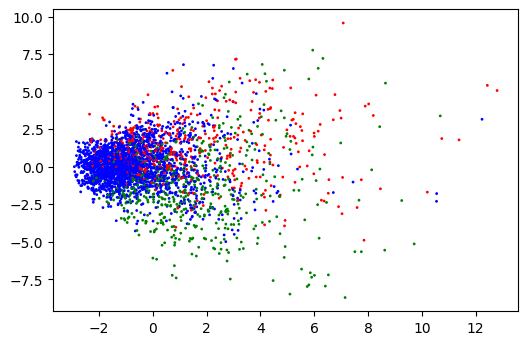

In [21]:
plot_clusters(
    data=original_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1,
    legend=False
)

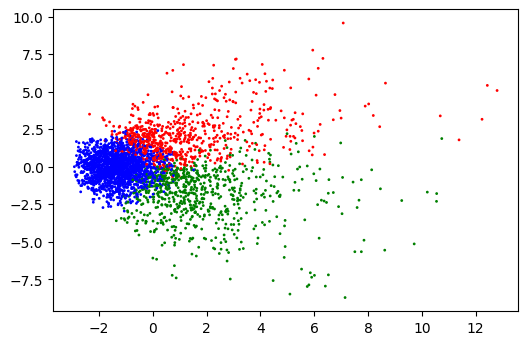

In [22]:
plot_clusters(
    data=original_embed,        
    cluster_labels=pred_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1,
    legend=False
)

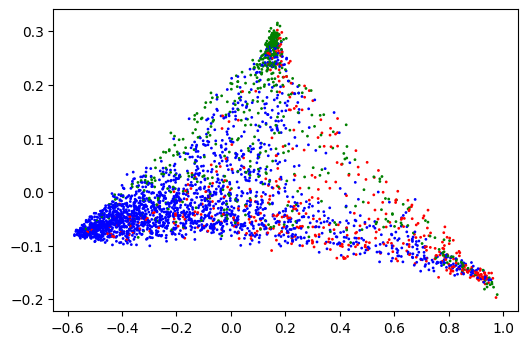

In [23]:
plot_clusters(
    data=latent_embed,        
    cluster_labels=true_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1,
    legend=False
)

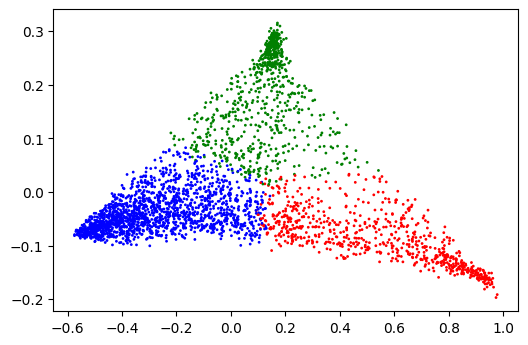

In [24]:
plot_clusters(
    data=latent_embed,        
    cluster_labels=pred_label,
    cluster_count=num_states,
    colors=['red', 'blue', 'green'],
    label_names=None,
    pca_components=2,
    title=None,
    save_path=None,
    dpi=100,
    marker_size=1,
    legend=False
)